# Market Basket Analysis in Python using Apriori Algorithm

--- Market Basket Analysis is a powerful tool for translating vast amounts of customer transaction and viewing data into simple
    rules for product promotion and recommendation. In this notebook, we’ll learn how to perform Market Basket Analysis using       the Apriori algorithm, standard and custom metrics, association rules, aggregation and pruning, and visualization.
    
##### The use cases of market basket analysis
    -  Build Netflix-style recommendations engine.
    -  Improve product recommendations on an e-commerce store.
    -  Cross-sell products in a retail setting.
    -  Improve inventory management.
    -  Upsell products.


In [4]:
!pip install mlxtend

##### imports

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [6]:
sns.set(style="darkgrid", color_codes=True)
pd.set_option('display.max_columns', 75)

#### Dataset¶

In [8]:
data = pd.read_csv(r'C:\Users\91880\Desktop\market basket\Market_Basket_Optimisation.csv', header = None)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7501 entries, 0 to 7500
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       7501 non-null   object
 1   1       5747 non-null   object
 2   2       4389 non-null   object
 3   3       3345 non-null   object
 4   4       2529 non-null   object
 5   5       1864 non-null   object
 6   6       1369 non-null   object
 7   7       981 non-null    object
 8   8       654 non-null    object
 9   9       395 non-null    object
 10  10      256 non-null    object
 11  11      154 non-null    object
 12  12      87 non-null     object
 13  13      47 non-null     object
 14  14      25 non-null     object
 15  15      8 non-null      object
 16  16      4 non-null      object
 17  17      4 non-null      object
 18  18      3 non-null      object
 19  19      1 non-null      object
dtypes: object(20)
memory usage: 1.1+ MB


In [9]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil
1,burgers,meatballs,eggs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chutney,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,turkey,avocado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mineral water,milk,energy bar,whole wheat rice,green tea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
data.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,7501,5747,4389,3345,2529,1864,1369,981,654,395,256,154,87,47,25,8,4,4,3,1
unique,115,117,115,114,110,106,102,98,88,80,66,50,43,28,19,8,3,3,3,1
top,mineral water,mineral water,mineral water,mineral water,green tea,french fries,green tea,green tea,green tea,green tea,low fat yogurt,green tea,green tea,green tea,magazines,salmon,frozen smoothie,protein bar,spinach,olive oil
freq,577,484,375,201,153,107,96,67,57,31,22,15,8,4,3,1,2,2,1,1


#### EDA

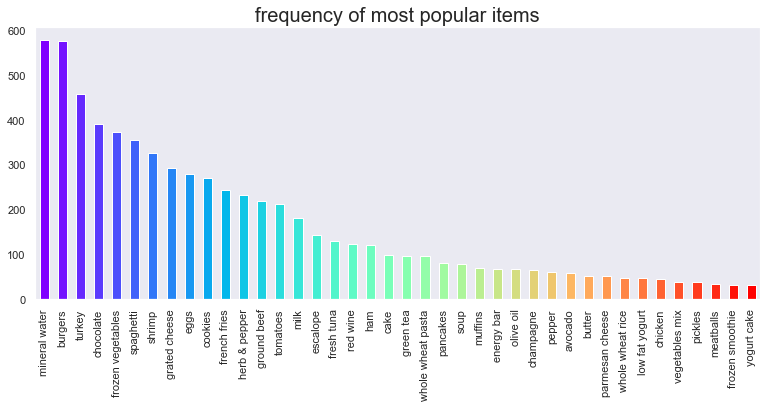

In [11]:
color = plt.cm.rainbow(np.linspace(0, 1, 40))
data[0].value_counts().head(40).plot.bar(color = color, figsize=(13,5))
plt.title('frequency of most popular items', fontsize = 20)
plt.xticks(rotation = 90 )
plt.grid()
plt.show()

In [12]:
import networkx as nx
data['food'] = 'Food'
food = data.truncate(before = -1, after = 15)
food = nx.from_pandas_edgelist(food, source = 'food', target = 0, edge_attr = True)

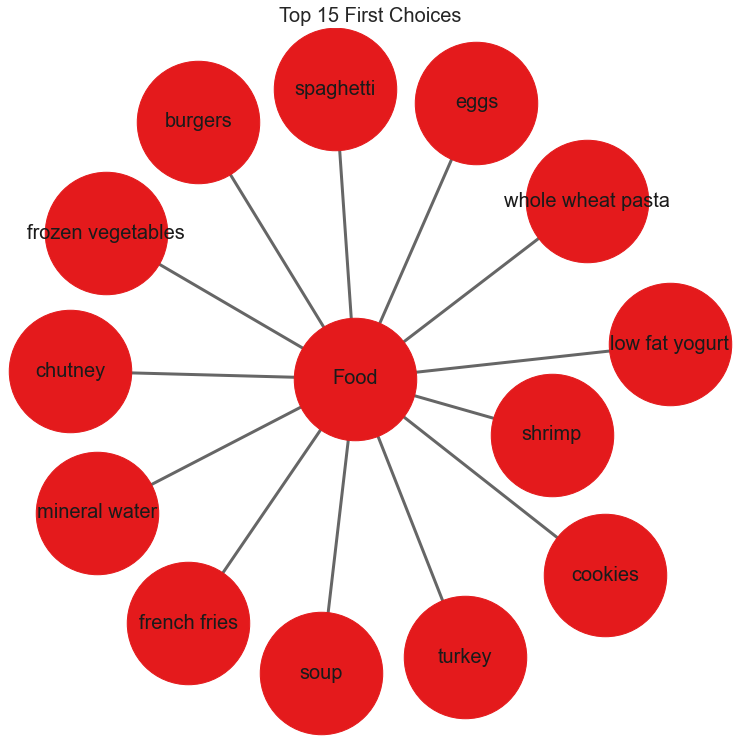

In [13]:
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (13, 13)
pos = nx.spring_layout(food)
color = plt.cm.Set1(np.linspace(0, 15, 1))
nx.draw_networkx_nodes(food, pos, node_size = 15000, node_color = color)
nx.draw_networkx_edges(food, pos, width = 3, alpha = 0.6, edge_color = 'black')
nx.draw_networkx_labels(food, pos, font_size = 20, font_family = 'sans-serif')
plt.axis('off')
plt.grid()
plt.title('Top 15 First Choices', fontsize = 20)
plt.show()

#### Getting the list of transactions

In [14]:
# Getting the list of transactions from the dataset
transactions = []
for i in range(0, len(data)):
    transactions.append([str(data.values[i,j]) for j in range(0, len(data.columns))])

In [15]:
transactions[:1]

[['shrimp',
  'almonds',
  'avocado',
  'vegetables mix',
  'green grapes',
  'whole weat flour',
  'yams',
  'cottage cheese',
  'energy drink',
  'tomato juice',
  'low fat yogurt',
  'green tea',
  'honey',
  'salad',
  'mineral water',
  'salmon',
  'antioxydant juice',
  'frozen smoothie',
  'spinach',
  'olive oil',
  'Food']]

#### Association rules

In [16]:
from itertools import permutations

# Extract unique items.
flattened = [item for transaction in transactions for item in transaction]
items = list(set(flattened))

In [17]:
print('# of items:',len(items))
print(list(items))

# of items: 122
['mint', 'cauliflower', 'chili', 'champagne', 'whole wheat rice', 'pasta', 'burger sauce', 'eggplant', 'gums', 'candy bars', 'honey', 'ketchup', 'black tea', 'oil', 'whole wheat pasta', 'red wine', 'soup', 'sandwich', 'almonds', 'ground beef', 'chocolate bread', 'yams', 'cooking oil', 'butter', 'spaghetti', 'asparagus', 'escalope', 'green tea', 'fresh bread', 'mint green tea', 'bacon', 'salt', 'mayonnaise', 'water spray', 'herb & pepper', 'melons', 'parmesan cheese', 'meatballs', 'nan', 'shallot', 'carrots', 'whole weat flour', 'bug spray', 'chocolate', 'green beans', 'spinach', 'chutney', 'mashed potato', 'light mayo', 'grated cheese', 'soda', 'tomato juice', 'clothes accessories', 'cookies', 'dessert wine', 'barbecue sauce', 'chicken', 'babies food', 'brownies', 'body spray', 'cereals', 'yogurt cake', 'zucchini', 'corn', 'pickles', 'cream', 'pepper', 'white wine', 'shrimp', 'toothpaste', 'mushroom cream sauce', 'fresh tuna', 'antioxydant juice', 'olive oil', 'cottage 

In [18]:
if 'nan' in items: items.remove('nan')
print(list(items))

['mint', 'cauliflower', 'chili', 'champagne', 'whole wheat rice', 'pasta', 'burger sauce', 'eggplant', 'gums', 'candy bars', 'honey', 'ketchup', 'black tea', 'oil', 'whole wheat pasta', 'red wine', 'soup', 'sandwich', 'almonds', 'ground beef', 'chocolate bread', 'yams', 'cooking oil', 'butter', 'spaghetti', 'asparagus', 'escalope', 'green tea', 'fresh bread', 'mint green tea', 'bacon', 'salt', 'mayonnaise', 'water spray', 'herb & pepper', 'melons', 'parmesan cheese', 'meatballs', 'shallot', 'carrots', 'whole weat flour', 'bug spray', 'chocolate', 'green beans', 'spinach', 'chutney', 'mashed potato', 'light mayo', 'grated cheese', 'soda', 'tomato juice', 'clothes accessories', 'cookies', 'dessert wine', 'barbecue sauce', 'chicken', 'babies food', 'brownies', 'body spray', 'cereals', 'yogurt cake', 'zucchini', 'corn', 'pickles', 'cream', 'pepper', 'white wine', 'shrimp', 'toothpaste', 'mushroom cream sauce', 'fresh tuna', 'antioxydant juice', 'olive oil', 'cottage cheese', 'energy bar', 

In [19]:
# Compute and print rules.
rules = list(permutations(items, 2))
print('# of rules:',len(rules))
print(rules[:5])

# of rules: 14520
[('mint', 'cauliflower'), ('mint', 'chili'), ('mint', 'champagne'), ('mint', 'whole wheat rice'), ('mint', 'pasta')]


#### One-hot encoding transaction data

In [20]:
# Import the transaction encoder function from mlxtend
from mlxtend.preprocessing import TransactionEncoder

# Instantiate transaction encoder and identify unique items
encoder = TransactionEncoder().fit(transactions)

# One-hot encode transactions
onehot = encoder.transform(transactions)

# Convert one-hot encoded data to DataFrame
onehot = pd.DataFrame(onehot, columns = encoder.columns_).drop('nan', axis=1)

# Print the one-hot encoded transaction dataset
onehot.head()

,asparagus,Food,almonds,antioxydant juice,asparagus,avocado,babies food,bacon,barbecue sauce,black tea,blueberries,body spray,bramble,brownies,bug spray,burger sauce,burgers,butter,cake,candy bars,carrots,cauliflower,cereals,champagne,chicken,chili,chocolate,chocolate bread,chutney,cider,clothes accessories,cookies,cooking oil,corn,cottage cheese,cream,dessert wine,...,parmesan cheese,pasta,pepper,pet food,pickles,protein bar,red wine,rice,salad,salmon,salt,sandwich,shallot,shampoo,shrimp,soda,soup,spaghetti,sparkling water,spinach,strawberries,strong cheese,tea,tomato juice,tomato sauce,tomatoes,toothpaste,turkey,vegetables mix,water spray,white wine,whole weat flour,whole wheat pasta,whole wheat rice,yams,yogurt cake,zucchini
0,False,True,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,True,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,True,False,False,True,False,False
1,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
4,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False


#### Metrics and pruning

In [21]:
# Compute the support
support = onehot.mean()
support = pd.DataFrame(support, columns=['support']).sort_values('support',ascending=False)

# Print the support
support.head()

,support
Food,1.000000
mineral water,0.238368
eggs,0.179709
spaghetti,0.174110
french fries,0.170911


In [22]:
support.describe()

,support
count,121.000000
mean,0.040611
std,0.097542
min,0.000133
25%,0.007732
50%,0.015731
75%,0.042528
max,1.000000


#### Confidence and lift

##### Recommending food with support

In [23]:
# Compute support for burgers and french fries
supportBF = np.logical_and(onehot['burgers'], onehot['french fries']).mean()

# Compute support for burgers and mineral water
supportBM = np.logical_and(onehot['burgers'], onehot['mineral water']).mean()

# Compute support for french fries and mineral water
supportFM = np.logical_and(onehot['french fries'], onehot['mineral water']).mean()

# Print support values
print("burgers and french fries: %.2f" % supportBF)
print("burgers and mineral water: %.2f" % supportBM)
print("french fries and mineral water: %.2f" % supportFM)

burgers and french fries: 0.02
burgers and mineral water: 0.02
french fries and mineral water: 0.03


#### Computing the support metric

In [24]:
# Add a mineral water+french fries column to the DataFrame onehot
onehot['mineral water+french fries'] = np.logical_and(onehot['mineral water'], onehot['french fries'])

# Compute the support
support = onehot.mean()
val = support.loc['mineral water+french fries']

# Print the support values
print(f'mineral water+french fries support = {val}')

mineral water+french fries support = 0.03372883615517931


#### Refining support with confidence

In [25]:
# Compute support for mineral water and french fries
supportMF = np.logical_and(onehot['mineral water'], onehot['french fries']).mean()

# Compute support for mineral water
supportM = onehot['mineral water'].mean()

# Compute support for french fries
supportF = onehot['french fries'].mean()

# Compute confidence for both rules
confidenceMM = supportMF / supportM
confidenceMF = supportMF / supportF

# Print results
print('mineral water = {0:.2f}, french fries = {1:.2f}'.format(confidenceMM, confidenceMF))

mineral water = 0.14, french fries = 0.20


#### Further refinement with lift

In [26]:
# Compute lift
lift = supportMF / (supportM * supportF)

# Print lift
print("Lift: %.2f" % lift)

Lift: 0.83


#### Leverage and Conviction

##### Computing conviction

In [27]:
# Compute support for burgers AND french fries
supportBF = np.logical_and(onehot['burgers'], onehot['french fries']).mean()

# Compute support for burgers
supportB = onehot['burgers'].mean()

# Compute support for NOT french fries
supportnF = 1.0 - onehot['french fries'].mean()

# Compute support for burgers and NOT french fries
supportBnF = supportB - supportBF

# Compute and print conviction for burgers -> french fries
conviction = supportB * supportnF / supportBnF
print("Conviction: %.2f" % conviction)

Conviction: 1.11


##### Computing conviction with a function

In [28]:
def conviction(antecedent, consequent):
    # Compute support for antecedent AND consequent
    supportAC = np.logical_and(antecedent, consequent).mean()

    # Compute support for antecedent
    supportA = antecedent.mean()

    # Compute support for NOT consequent
    supportnC = 1.0 - consequent.mean()

    # Compute support for antecedent and NOT consequent
    supportAnC = supportA - supportAC

    # Return conviction
    return supportA * supportnC / supportAnC

##### Computing leverage with a function

In [29]:
def leverage(antecedent, consequent):
    # Compute support for antecedent AND consequent
    supportAB = np.logical_and(antecedent, consequent).mean()

    # Compute support for antecedent
    supportA = antecedent.mean()

    # Compute support for consequent
    supportB = consequent.mean()

    # Return leverage
    return supportAB - supportB * supportA

##### Promoting food with conviction

In [30]:
# Compute conviction for burgers -> french fries and french fries -> burgers
convictionBF = conviction(onehot['burgers'], onehot['french fries'])
convictionFB = conviction(onehot['french fries'], onehot['burgers'])

# Compute conviction for burgers -> mineral water and mineral water -> burgers
convictionBM = conviction(onehot['burgers'], onehot['mineral water'])
convictionMB = conviction(onehot['mineral water'], onehot['burgers'])

# Compute conviction for french fries -> mineral water and mineral water -> french fries
convictionFM = conviction(onehot['french fries'], onehot['mineral water'])
convictionMF = conviction(onehot['mineral water'], onehot['french fries'])

# Print results
print('french fries -> burgers: ', convictionFB)
print('burgers -> french fries: ', convictionBF)

french fries -> burgers:  1.0476495106531305
burgers -> french fries:  1.1088435652342468


#### Association and Dissociation

##### Computing association and dissociation

In [31]:
# Compute the support of burgers and french fries
supportT = onehot['burgers'].mean()
supportP = onehot['french fries'].mean()

# Compute the support of both food items
supportTP = np.logical_and(onehot['burgers'], onehot['french fries']).mean()

# Complete the expressions for the numerator and denominator
numerator = supportTP - supportT*supportP
denominator = max(supportTP*(1-supportT), supportT*(supportP-supportTP))

# Compute and print Zhang's metric
zhang = numerator / denominator
print(zhang)

0.3533836982354581


#### Defining Zhang's metric

In [32]:
# Define a function to compute Zhang's metric
def zhang(antecedent, consequent):
    # Compute the support of each book
    supportA = antecedent.mean()
    supportC = consequent.mean()

    # Compute the support of both books
    supportAC = np.logical_and(antecedent, consequent).mean()

    # Complete the expressions for the numerator and denominator
    numerator = supportAC - supportA*supportC
    denominator = max(supportAC*(1-supportA), supportA*(supportC-supportAC))

    # Return Zhang's metric
    return numerator / denominator

#### Applying Zhang's metric

In [33]:
# Create rules DataFrame
rules_ = pd.DataFrame(rules, columns=['antecedents','consequents'])

# Define an empty list for metrics
zhangs, conv, lev, antec_supp, cons_supp, suppt, conf, lft = [], [], [], [], [], [], [], []

# Loop over lists in itemsets
for itemset in rules:
    # Extract the antecedent and consequent columns
    antecedent = onehot[itemset[0]]
    consequent = onehot[itemset[1]]
    
    antecedent_support = onehot[itemset[0]].mean()
    consequent_support = onehot[itemset[1]].mean()
    support = np.logical_and(onehot[itemset[0]], onehot[itemset[1]]).mean()
    confidence = support / antecedent_support
    lift = support / (antecedent_support * consequent_support)
    
    # Complete metrics and append it to the list
    antec_supp.append(antecedent_support)
    cons_supp.append(consequent_support)
    suppt.append(support)
    conf.append(confidence)
    lft.append(lift)
    lev.append(leverage(antecedent, consequent))
    conv.append(conviction(antecedent, consequent))
    zhangs.append(zhang(antecedent, consequent))
    
# Store results
rules_['antecedent support'] = antec_supp
rules_['consequent support'] = cons_supp
rules_['support'] = suppt
rules_['confidence'] = conf
rules_['lift'] = lft
rules_['leverage'] = lev
rules_['conviction'] = conv
rules_['zhang'] = zhangs

# Print results
rules_.sort_values('zhang',ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhang
1790,whole wheat pasta,asparagus,0.029463,0.000133,0.000133,0.004525,33.941176,0.000129,1.004412,1.0
5150,chocolate,asparagus,0.163845,0.000133,0.000133,0.000814,6.103336,0.000111,1.000681,1.0
8990,energy bar,asparagus,0.027063,0.000133,0.000133,0.004926,36.950739,0.000130,1.004817,1.0
8150,shrimp,asparagus,0.071457,0.000133,0.000133,0.001866,13.994403,0.000124,1.001736,1.0
13551,burgers,asparagus,0.087188,0.000133,0.000133,0.001529,11.469419,0.000122,1.001398,1.0


In [34]:
rules_.describe()

,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhang
count,14520.000000,14520.000000,14520.000000,14520.000000,14520.000000,14520.000000,1.440000e+04,14400.000000
mean,0.040611,0.040611,0.001906,0.052663,1.467719,0.000335,inf,-0.011728
std,0.097141,0.097141,0.007505,0.108745,1.864950,0.001148,NaN,0.621009
min,0.000133,0.000133,0.000000,0.000000,0.000000,-0.011697,7.616318e-01,-1.000000
25%,0.007732,0.007732,0.000133,0.004975,0.500009,-0.000046,9.953340e-01,-0.517778
50%,0.015731,0.015731,0.000400,0.021849,1.214494,0.000079,1.003948e+00,0.192710
75%,0.042528,0.042528,0.001333,0.058140,1.858384,0.000361,1.020828e+00,0.483074
max,1.000000,1.000000,0.238368,1.000000,45.460606,0.022088,inf,1.000000


In [35]:
rules_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14520 entries, 0 to 14519
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   antecedents         14520 non-null  object 
 1   consequents         14520 non-null  object 
 2   antecedent support  14520 non-null  float64
 3   consequent support  14520 non-null  float64
 4   support             14520 non-null  float64
 5   confidence          14520 non-null  float64
 6   lift                14520 non-null  float64
 7   leverage            14520 non-null  float64
 8   conviction          14400 non-null  float64
 9   zhang               14400 non-null  float64
dtypes: float64(8), object(2)
memory usage: 1.1+ MB


#### Overview of market basket analysis

###### Filtering with support and conviction

In [36]:
# Select the subset of rules with antecedent support greater than 0.05
rules_filtered = rules_[rules_['antecedent support'] > 0.05]

# Select the subset of rules with a consequent support greater than 0.01
rules_filtered = rules_[rules_['consequent support'] > 0.01]

# Select the subset of rules with a conviction greater than 1.01
rules_filtered = rules_[rules_['conviction'] > 1.01]

# Select the subset of rules with a lift greater than 1.0
rules_filtered = rules_[rules_['lift'] > 1.0]

# Print remaining rules
print(f'# of rules = {len(rules_)}')
print(f'# of rules after filtering = {len(rules_filtered)}')
print(rules_filtered.head())

# of rules = 14520
# of rules after filtering = 8598
  antecedents       consequents  antecedent support  consequent support  \
0        mint       cauliflower            0.017464            0.004799   
1        mint             chili            0.017464            0.006133   
3        mint  whole wheat rice            0.017464            0.058526   
5        mint      burger sauce            0.017464            0.005866   
6        mint          eggplant            0.017464            0.013198   

    support  confidence      lift  leverage  conviction     zhang  
0  0.000267    0.015267  3.181086  0.000183    1.010630  0.697829  
1  0.000133    0.007634  1.244773  0.000026    1.001513  0.200136  
3  0.001333    0.076336  1.304318  0.000311    1.019282  0.237463  
5  0.000267    0.015267  2.602706  0.000164    1.009547  0.626730  
6  0.000267    0.015267  1.156758  0.000036    1.002101  0.137924  


##### Using multi-metric filtering to cross-promote food items

In [37]:
# Set the threshold for Zhang's rule to 0.65
rules_filtered = rules_filtered[rules_filtered['zhang'] > 0.65]

# Print rule
print(f'# of rules after filtering = {8598 - len(rules_filtered)}')
print(rules_filtered.head())

# of rules after filtering = 6911
   antecedents          consequents  antecedent support  consequent support  \
0         mint          cauliflower            0.017464            0.004799   
34        mint               melons            0.017464            0.011998   
35        mint      parmesan cheese            0.017464            0.019864   
50        mint  clothes accessories            0.017464            0.008399   
62        mint              pickles            0.017464            0.005999   

     support  confidence      lift  leverage  conviction     zhang  
0   0.000267    0.015267  3.181086  0.000183    1.010630  0.697829  
34  0.000667    0.038168  3.181086  0.000457    1.027208  0.697829  
35  0.001200    0.068702  3.458630  0.000853    1.052441  0.723504  
50  0.000667    0.038168  4.544408  0.000520    1.030950  0.793813  
62  0.000400    0.022901  3.817303  0.000295    1.017298  0.751153  


####                                                                             THANK YOU 